In [132]:
import numpy as np
import scipy as sp
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy import sparse
from sklearn.svm import SVC
from sklearn import svm

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
import nltk
import math
import matplotlib.pyplot as plt

In [2]:
def read_data():

    # Training set
    with open('mex20_train.txt', 'r') as f:
        corpus_train = f.readlines()
    with open('mex20_train_labels.txt', 'r') as f:
        labels_train = f.readlines()
    labels_train = [int(lab.strip('\n')) for lab in labels_train]
    tweets_train = [tw.strip('\n') for tw in corpus_train]

    # Validation set
    with open('mex20_val.txt', 'r') as f:
        corpus_val = f.readlines()
    with open('mex20_val_labels.txt', 'r') as f:
        labels_val = f.readlines()
    labels_val = [int(lab.strip('\n')) for lab in labels_val]
    tweets_val = [tw.strip('\n') for tw in corpus_val]

    # Test set
    with open('mex20_test_full.txt', 'r') as f:
        corpus_test = f.readlines()
    tweets_test = [tw.strip('\n') for tw in corpus_test]

    return tweets_train, labels_train, tweets_val, labels_val, tweets_test

In [152]:
X_train_, y_train, X_val_, y_val, X_test_ = read_data()
print("{0} for training\n{1} for validation\n{2} for test".format(len(X_train_), len(X_val_), len(X_test_)))

5278 for training
587 for validation
1467 for test


## BOW Representations

In [169]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1,3), min_df = 2, max_df = 1000)
X_train = vectorizer.fit_transform(X_train_)
X_val = vectorizer.transform(X_val_)
X_test = vectorizer.transform(X_test_)

In [170]:
vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (4,5), min_df = 8, max_df = 1000)
X_train2 = vectorizer.fit_transform(X_train_)
X_val2 = vectorizer.transform(X_val_)
X_test2 = vectorizer.transform(X_test_)

In [155]:
X_train.shape

(5278, 14755)

In [168]:
X_train2.shape

(5278, 17468)

In [171]:
select = SelectKBest(mutual_info_classif, k=5000)
select.fit(X_train, y_train)
X_train = select.transform(X_train)
X_val = select.transform(X_val)
X_test = select.transform(X_test)

In [172]:
select = SelectKBest(mutual_info_classif, k=2000)
select.fit(X_train2, y_train)
X_train2 = select.transform(X_train2)
X_val2 = select.transform(X_val2)
X_test2 = select.transform(X_test2)

In [120]:
X_train = sparse.vstack([X_train, X_val])
y_train = y_train+y_val

In [189]:
X_train = sparse.vstack([X_train_concat, X_val_concat])
y_train = y_train+y_val

In [141]:
X_train.shape

(5278, 5000)

In [142]:
X_train2.shape

(5278, 5000)

In [143]:
X_val.shape

(587, 5000)

In [183]:
X_train_concat = sp.sparse.hstack([X_train, X_train2])
X_val_concat = sp.sparse.hstack([X_val, X_val2])
X_test_concat = sp.sparse.hstack([X_test, X_test2])

In [184]:
X_train_concat.shape

(5278, 7000)

In [185]:
parameters = {'C': [.01, .05, 0.8, 0.1, .12, .25]}
svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5, verbose=3)

In [76]:
parameters = {'C': [.05, .1, .25, 1., 2., 3.5, 4., 8., 10.], 'gamma': [0.01,  0.05, 0.1, 0.5, 1.]}
svr = SVC()
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5, verbose=3)

In [175]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of  30 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=8,
             param_grid={'C': [0.01, 0.05, 0.8, 0.1, 0.12, 0.25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=3)

In [186]:
grid.fit(X_train_concat, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    3.5s finished
/home/isaac/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=8,
             param_grid={'C': [0.01, 0.05, 0.8, 0.1, 0.12, 0.25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=3)

In [ ]:
y_pred = grid.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

In [187]:
y_pred = grid.predict(X_val_concat)
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       418
           1       0.77      0.75      0.76       169

    accuracy                           0.86       587
   macro avg       0.84      0.83      0.83       587
weighted avg       0.86      0.86      0.86       587



In [188]:
print(grid.best_estimator_)

LinearSVC(C=0.05, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [ ]:
svr = SVC(C=4, gamma=0.5)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

In [190]:
svr = svm.LinearSVC(class_weight='balanced', C=0.05)
svr.fit(X_train, y_train)

LinearSVC(C=0.05, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [192]:
y_pred_test = svr.predict(X_test_concat)

In [193]:
with open('test_pred.txt', 'w') as f:
    f.write("id,Expected\n")
    for i in range(len(y_pred_test)):
        f.write("{0},{1}\n".format(i,y_pred_test[i]))

In [236]:
f_scores_val = []
f_scores_train = []
reg = np.array(np.arange(3.0, 4.5, 0.1))

for c in reg:
    svr = SVC(C=c, gamma=0.5)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_val)
    f_scores_val.append(f1_score(y_val, y_pred, average='macro'))
    y_pred = svr.predict(X_train)
    f_scores_train.append(f1_score(y_train, y_pred, average='macro'))

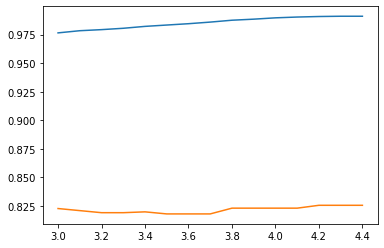

In [237]:
plt.plot(reg, f_scores_train)
plt.plot(reg, f_scores_val)
plt.show()

In [ ]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

In [86]:
reg = np.array(np.arange(0.001, 0.3, 0.01))
train_score, val_score = validation_curve(svm.LinearSVC(class_weight='balanced'), X_train, y_train,
                                          param_name="C", param_range=reg, cv=5, scoring="f1_macro")

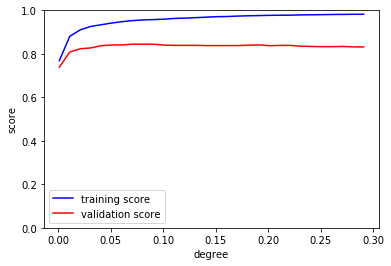

In [87]:
plt.plot(reg, np.median(train_score, 1), color='blue', label='training score')
plt.plot(reg, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

#### Experiments with countVectorizer - ngram word

Exp1:

* KAGGLE: 0.78802
* SVC with C=3.2, gamma=0.06, kernel='rbf'
* CountVectorizer with ngram by word(1,3), min_df=8, max_df=1000

                precision    recall  f1-score   support

           0       0.86      0.94      0.90       418
           1       0.82      0.63      0.72       169

    accuracy                           0.86       587
   macro avg       0.84      0.79      0.81       587
weighted avg       0.85      0.86      0.85       587


Exp2:

* SVC with C=3.6, gamma=0.05, kernel='rbf'
* CountVectorizer with ngram by word(1,3), min_df=7, max_df=2000

                precision    recall  f1-score   support

           0       0.86      0.94      0.90       418
           1       0.82      0.62      0.70       169

    accuracy                           0.85       587
   macro avg       0.84      0.78      0.80       587
weighted avg       0.85      0.85      0.84       587


Exp3:

* SVC with C=3.4, gamma=0.04, kernel='rbf'
* CountVectorizer with ngram by word(1,3), min_df=8, max_df=2000

                precision    recall  f1-score   support

           0       0.87      0.94      0.90       418
           1       0.81      0.64      0.72       169

    accuracy                           0.85       587
   macro avg       0.84      0.79      0.81       587
weighted avg       0.85      0.85      0.85       587


Exp4:

* SVC with C=3.1, gamma=0.04, kernel='rbf'
* CountVectorizer with ngram by word(1,3), min_df=10, max_df=2000

                precision    recall  f1-score   support

           0       0.85      0.94      0.90       418
           1       0.81      0.60      0.69       169

    accuracy                           0.84       587
   macro avg       0.83      0.77      0.79       587
weighted avg       0.84      0.84      0.84       587


Exp5:

* SVC with C=2.9, gamma=0.05, kernel='rbf'
* CountVectorizer with ngram by word(1,3), min_df=8, max_df=2500

                precision    recall  f1-score   support

           0       0.85      0.95      0.90       418
           1       0.83      0.59      0.69       169

    accuracy                           0.85       587
   macro avg       0.84      0.77      0.79       587
weighted avg       0.84      0.85      0.84       587


Exp6:

* SVC with C=3, gamma=0.05, kernel='rbf'
* CountVectorizer with ngram by word(1,3), min_df=10, max_df=2500

                precision    recall  f1-score   support

           0       0.85      0.94      0.89       418
           1       0.81      0.58      0.68       169

    accuracy                           0.84       587
   macro avg       0.83      0.76      0.78       587
weighted avg       0.84      0.84      0.83       587

#### Experiments with countVectorizer - ngram char

Exp1:

* SVC with C=3.5, gamma=0.001, kernel='rbf'
* CountVectorizer with ngram by char(3,7), min_df=1, max_df=1000

                precision    recall  f1-score   support

           0       0.80      0.90      0.85       397
           1       0.78      0.60      0.68       219

    accuracy                           0.80       616
   macro avg       0.79      0.75      0.77       616
weighted avg       0.79      0.80      0.79       616


Exp2:

* SVC with C=3.5, gamma=0.001, kernel='rbf'
* CountVectorizer with ngram by char(4,7), min_df=10, max_df=1000

                precision    recall  f1-score   support

           0       0.80      0.91      0.85       397
           1       0.78      0.60      0.68       219

    accuracy                           0.80       616
   macro avg       0.79      0.75      0.77       616
weighted avg       0.80      0.80      0.79       616

#### Experiments with TfidfVectorizer - ngram word

Exp1:

* KAGGLE: 0.77525
* SVC with C=3.7, gamma=0.5, kernel='rbf'
* TfidfVectorizer with ngram by word(1,3), min_df=8, max_df=1000

                precision    recall  f1-score   support

           0       0.88      0.93      0.90       418
           1       0.79      0.69      0.73       169

    accuracy                           0.86       587
   macro avg       0.83      0.81      0.82       587
weighted avg       0.85      0.86      0.85       587

Exp2:

* SVC with C=4, gamma=0.5, kernel='rbf'
* TfidfVectorizer with ngram by word(1,3), min_df=10, max_df=2000

                precision    recall  f1-score   support

           0       0.84      0.88      0.86       397
           1       0.76      0.69      0.72       219

    accuracy                           0.81       616
   macro avg       0.80      0.78      0.79       616
weighted avg       0.81      0.81      0.81       616

Exp3:

* SVC with C=3, gamma=0.3, kernel='rbf'
* TfidfVectorizer with ngram by word(1,3), min_df=10, max_df=2500

                precision    recall  f1-score   support

           0       0.86      0.94      0.89       418
           1       0.80      0.61      0.69       169

    accuracy                           0.84       587
   macro avg       0.83      0.77      0.79       587
weighted avg       0.84      0.84      0.84       587

#### Experiments with TfidfVectorizer - ngram char

Exp1:

* SVC with C=4, gamma=0.3, kernel='rbf'
* TfidfVectorizer with ngram by char(4,7), min_df=10, max_df=2000

                precision    recall  f1-score   support

           0       0.86      0.93      0.90       418
           1       0.79      0.64      0.71       169

    accuracy                           0.85       587
   macro avg       0.83      0.79      0.80       587
weighted avg       0.84      0.85      0.84       587

### Kaggle

Model1:
    * Kaggle Score: 0.80729
    * LinearSVC (C = 0.05)
    * CountVectorizer - word (1, 3)
    * (min_df, max_df) = (2, 2000)
    * SelectKBest - mutual_info_classif (k = 5000)
    
                  precision    recall  f1-score   support

           0       0.90      0.90      0.90       418
           1       0.75      0.75      0.75       169

    accuracy                           0.85       587
   macro avg       0.82      0.82      0.82       587
weighted avg       0.85      0.85      0.85       587


Model2:
    * Kaggle Score: 
    * LinearSVC (C = 0.05)
    * CountVectorizer - word (1, 3)
    * (min_df, max_df) = (2, 2000)
    * SelectKBest - mutual_info_classif (k = 5000)
    


## DOR Representation

In [8]:
def process_word(w, punct):
    is_punct = True if w in punct else False
    is_digit = w.isnumeric()
    is_stopword = w in stopwords.words('spanish')

    return "" if is_punct or is_digit or is_stopword else w.lower()

In [9]:
def words_to_ngrams(words, n, sep=" "):
    if n > 1:
        return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    else:
        return words

In [10]:
def build_ngrams(tweets, punct, n):
    tk = TweetTokenizer()
    tokens = [process_word(w, punct) for sent in tweets for w in tk.tokenize(sent)]
    tokens = list(filter(None, tokens))
    tw_grams = words_to_ngrams(tokens, n)
    tw_grams = FreqDist(tw_grams)
    
    return tw_grams

In [11]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [12]:
punct = set(['.', ',', ';', ':', '-', '!', '¡', '¿', '?', '"', '\'',
             '...', '…', '️', '(', ')', '<url>', '*', '@usuario',
            '“', '”', '..', '/'])

In [13]:
fdist = build_ngrams(X_train, punct, 1)

In [14]:
V = sortFreqDict(fdist)

In [15]:
V = V[:5000]

In [16]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1 

In [17]:
def build_bow_tr(tr_txt, V, dict_indices):
    tk = TweetTokenizer()
    BOW = np.zeros((len(tr_txt),len(V)), dtype=int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tk.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1       
    return BOW

In [18]:
def compute_dor(TR):
    
    DTR = np.zeros((TR.shape[1], TR.shape[0]), dtype=np.float)

    tam_V = TR.shape[1]
    for doc, i in zip(TR, range(len(TR))):
        nonzero_positions = np.nonzero(doc)[0] # returns a tuple of n-dimensions. Since we have 1D array docs, it returns a tuple with one element. thus, we get the 0 index.
        tam_v = len(nonzero_positions)
        for term in nonzero_positions:
            DTR[term, i] = (1 + math.log10(doc[term])) * math.log10(tam_V/tam_v)
    return DTR

In [46]:
def compute_dor_docs(TR, tr_txt):
    
    DDR = np.zeros((len(tr_txt), TR.shape[1]), dtype=np.float)
    tk = TweetTokenizer()

    for tr, i in zip(tr_txt, range(len(tr_txt))):
        doc = np.zeros(TR.shape[1])
        for word in tk.tokenize(tr):
            if word in dict_indices:
                doc = np.add(doc, TR[dict_indices[word],:])
        DDR[i] = doc
    
    return DDR

In [ ]:
BOW_tr = build_bow_tr(X_train, V, dict_indices)
BOW_val = build_bow_tr(X_val, V, dict_indices)

In [21]:
print(BOW_tr.shape)
print(BOW_val.shape)

(5544, 5000)
(616, 5000)


In [22]:
DOR_tr = compute_dor(BOW_tr)
DOR_val = compute_dor(BOW_val)
#DOR_base = preprocessing.normalize(DOR_tr, norm='l2')

In [23]:
print(DOR_tr.shape)
print(DOR_val.shape)

(5000, 5544)
(5000, 616)


In [ ]:
X_DOR_train = compute_dor_docs(DOR_tr, X_train)
X_DOR_val = compute_dor_docs(DOR_tr, X_val)

In [26]:
print(X_DOR_train.shape)
print(X_DOR_val.shape)

(5544, 5544)
(616, 5544)


In [27]:
parameters = {'C': [1.5, 2, 2.5, 3, 3.5], 'gamma': [0.005, 0.01, 0.05, 0.1, 0.5]}
svr = SVC()
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=5, verbose=3)

In [ ]:
grid.fit(X_DOR_train, y_train)

In [ ]:
svr = SVC(C=2.5, gamma=0.05)
svr.fit(X_DOR_train, y_train)
y_pred = svr.predict(X_DOR_val)
print(metrics.classification_report(y_val, y_pred))

In [36]:
type(X_train)

scipy.sparse.csr.csr_matrix